## Distributed Data Parallel

### Dependencies

In [1]:
import os
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from sklearn.metrics import classification_report, f1_score
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, DistributedSampler, random_split
import torchvision.models as models
from tqdm import tqdm

# Suppress all UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Set environment variables

In [2]:

os.environ["MASTER_ADDR"] = "127.0.0.1"  # Set the master address
os.environ["MASTER_PORT"] = "29500"      # Set the master port


In Distributed Data Parallel (DDP), these environment variables are used to set the address and port of the master process, which coordinates communication between the different processes involved in distributed training. Specifically:

- `MASTER_ADDR`: The master process is responsible for coordinating communication among all the processes participating in distributed training.
  
- `MASTER_PORT`: This environment variable sets the port number on which the master process listens for communication from other processes.


### Helper Functions

In [3]:
# Define the EfficientNetB3-based model with custom classifier
class EfficientNetB3(nn.Module):
    """
    EfficientNetB3-based model with a custom classifier.

    This model utilizes the EfficientNetB3 architecture as the base model with a custom classifier
    appended to the feature extractor. The original classifier is removed, and a new linear layer is added
    to classify the input into the specified number of classes.

    Args:
        num_classes (int): The number of output classes.

    Attributes:
        base_model (torch.nn.Module): The EfficientNetB3 base model.
        classifier (torch.nn.Linear): Custom classifier added for classification.

    Methods:
        forward(x): Performs forward pass through the network.
    """

    def __init__(self, num_classes):
        """
        Initializes the EfficientNetB3-based model with a custom classifier.

        Args:
            num_classes (int): The number of output classes.
        """
        super(EfficientNetB3, self).__init__()
        self.base_model = models.efficientnet_b3(pretrained=True)
        self.base_model.classifier = nn.Identity()  # Remove original classifier
        # Calculate the number of input features dynamically
        num_features = self.base_model(torch.zeros(1, 3, 224, 224)).shape[1]
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        """
        Performs forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor to the network.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.base_model(x)
        x = self.classifier(x)
        return x


class CustomDataset(torch.utils.data.Dataset):
    """
    A custom PyTorch Dataset class for loading image data from a directory.

    Args:
        data_dir (str): Path to the root directory containing the image data.
        train (bool): Whether the dataset is used for training or not. Default is True.
        transform (callable, optional): Optional transform to be applied to the images. Default is None.
        train_size (float): The proportion of the dataset to use for training if train=True. Default is 0.9.
    """
    def __init__(self, data_dir, train=True, transform=None, train_size=0.9):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.train_size = train_size

        if self.train:
            self.dataset = ImageFolder(root=self.data_dir, transform=self.transform)
            # Split the dataset into train and validation sets based on the train_size
            train_len = int(self.train_size * len(self.dataset))
            val_len = len(self.dataset) - train_len
            self.dataset, _ = torch.utils.data.random_split(self.dataset, [train_len, val_len])
        else:
            self.dataset = ImageFolder(root=self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [4]:
def setup_ddp(rank, world_size):
    '''
    Initialize the process group
    rank: Particular GPU (a unique identifier)
    world_size: NO of GPU available
    '''
    dist.init_process_group(backend='nccl', init_method='env://', world_size=world_size, rank=rank)
    torch.cuda.set_device(rank)

def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    """
    Train the given model using the provided data loaders.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        valid_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): The loss function used for optimization.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        device (torch.device): The device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs to train the model.

    Returns:
        classification_reports (list): List containing classification reports from each GPU.
    """
    total_start = time.time()
    model.train()
    epoch_times = []  # List to store time taken for each epoch
    for epoch in range(num_epochs):
        start_time = time.time()  # Record start time of epoch
        
        train_losses = []
        valid_losses = []
        train_correct = 0
        valid_correct = 0
        train_total = 0
        valid_total = 0

        # Training loop
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss
            train_losses.append(loss.item())

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_accuracy = train_correct / train_total

            # Update progress bar
            pbar.set_postfix({'Train Loss': loss.item(), 'Train Acc': train_accuracy})

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Track validation loss
                valid_losses.append(loss.item())

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                valid_accuracy = valid_correct / valid_total

        # Calculate average losses and accuracies
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_valid_loss = sum(valid_losses) / len(valid_losses)
        train_accuracy = train_correct / train_total
        valid_accuracy = valid_correct / valid_total

        # Record end time of epoch
        end_time = time.time()
        epoch_duration = end_time - start_time
        epoch_times.append(epoch_duration)

        # Print epoch summary including time taken
        print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Avg Valid Loss: {avg_valid_loss:.4f}, Train Acc: {train_accuracy:.4f}, Valid Acc: {valid_accuracy:.4f}, Time: {epoch_duration:.2f} seconds')
        

    total_end = time.time()
    total_exec_time = total_end - total_start
    print(f"Total execution time : {total_exec_time:.2f}s")

    # Plotting time taken over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_times, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Time Taken Over Epochs')
    plt.grid(True)
    plt.show()   
    
    evaluate_model(model, valid_loader, criterion, device)

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the given model on the provided data.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the evaluation data.
        criterion: The loss function used for evaluation.
        device (torch.device): Device where the computation will take place (e.g., 'cuda' or 'cpu').

    Returns:
        Tuple of accuracy and average loss.
    """
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    # avg_loss = total_loss / len(dataloader)

    # Classification report
    class_report = classification_report(all_targets, all_predictions, zero_division=1, output_dict=True)
    weighted_avg_accuracy = class_report['weighted avg']['precision']
    # weighted_avg_f1_score = class_report['weighted avg']['f1-score']
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Weighted Average Accuracy: {weighted_avg_accuracy:.4f}')

    return accuracy, weighted_avg_accuracy

In [5]:
def initialize_and_train(rank, world_size):
    """
    Initialize distributed training and train the model.

    Args:
        rank (int): Rank of the current process in the distributed setup.
        world_size (int): Total number of GPUs in the distributed setup.
    """
    # Initialize distributed training
    setup_ddp(rank, world_size)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Hyperparameters
    batch_size = 32
    num_epochs = 20
    learning_rate = 0.001
    
    # Data preprocessing
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(root=data_dir, transform=transform)

    # Split dataset into training and validation sets
    train_size = int(0.9 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    
    # Distributed sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=world_size, rank=rank)
    
    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    
    # Model
    num_classes = 2  # Adjust based on your dataset
    model = EfficientNetB3(num_classes=num_classes).to(device)
    model = DDP(model, device_ids=[rank])
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Print resource and data information
    print(f'Rank: {rank}\n')
    print(f'World Size(GPU Count): {world_size}\n')
    print(f'Total Samples: {len(dataset)}')
    print(f'Total Training Samples: {len(train_dataset)}, Total Validation Samples: {len(valid_dataset)}\n')
    print(f'GPU Memory: {torch.cuda.get_device_properties(rank).total_memory / 1024 ** 3:.2f} GB\n')
    
    # Train the model
    train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs)

### Preprocessing (Define dimensions and Normalize)

In [6]:
# Define image dimensions
img_height = 224
img_width = 224
data_dir = "/home/sikhakolli.v/Real_VS_AI/CASIA/Au"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### Initialize the training process

Number of GPUs: 4

Rank: 0
Rank: 1


Rank: 2
World Size(GPU Count): 4
Rank: 3
World Size(GPU Count): 4




World Size(GPU Count): 4
Total Samples: 12614World Size(GPU Count): 4
Total Samples: 12614



Total Samples: 12614Total Training Samples: 11352, Total Validation Samples: 1262
Total Samples: 12614Total Training Samples: 11352, Total Validation Samples: 1262




Total Training Samples: 11352, Total Validation Samples: 1262
GPU Memory: 31.74 GB
GPU Memory: 31.74 GB
Total Training Samples: 11352, Total Validation Samples: 1262




GPU Memory: 31.74 GB
GPU Memory: 31.74 GB



Epoch 1/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it, Train Loss=0.348, Train Acc=0.774]

Epoch 1/20: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it, Train Loss=0.462, Train Acc=0.784]



Epoch [1/20], Avg Train Loss: 0.4602, Avg Valid Loss: 0.3764, Train Acc: 0.7844, Valid Acc: 0.8196, Time: 106.87 secondsEpoch [1/20], Avg Train Loss: 0.4612, Avg Valid Loss: 0.3897, Train Acc: 0.7784, Valid Acc: 0.8006, Time: 106.87 seconds



Epoch 2/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [1/20], Avg Train Loss: 0.4717, Avg Valid Loss: 0.3863, Train Acc: 0.7667, Valid Acc: 0.7911, Time: 107.01 seconds


Epoch 2/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [1/20], Avg Train Loss: 0.4838, Avg Valid Loss: 0.3751, Train Acc: 0.7745, Valid Acc: 0.8291, Time: 107.69 seconds


Epoch 2/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=4.49e+3, Train Acc=0.528]





Epoch [2/20], Avg Train Loss: 17338.6930, Avg Valid Loss: 8061.5865, Train Acc: 0.5282, Valid Acc: 0.5190, Time: 95.53 seconds


Epoch 3/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [2/20], Avg Train Loss: 15407.7139, Avg Valid Loss: 7925.4657, Train Acc: 0.5588, Valid Acc: 0.5570, Time: 95.56 seconds
Epoch [2/20], Avg Train Loss: 16756.3127, Avg Valid Loss: 8417.7824, Train Acc: 0.5285, Valid Acc: 0.5570, Time: 94.74 seconds

Epoch 3/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [2/20], Avg Train Loss: 16053.6353, Avg Valid Loss: 7715.8821, Train Acc: 0.5585, Valid Acc: 0.5316, Time: 95.56 seconds


Epoch 3/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=719, Train Acc=0.494]    





Epoch [3/20], Avg Train Loss: 932717.2053, Avg Valid Loss: 4244.4921, Train Acc: 0.4944, Valid Acc: 0.4241, Time: 95.61 seconds


Epoch 4/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [3/20], Avg Train Loss: 763438.5696, Avg Valid Loss: 4352.9495, Train Acc: 0.4827, Valid Acc: 0.4082, Time: 95.61 seconds
Epoch [3/20], Avg Train Loss: 652260.0908, Avg Valid Loss: 4238.1077, Train Acc: 0.5127, Valid Acc: 0.4241, Time: 95.71 seconds

Epoch 4/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [3/20], Avg Train Loss: 736195.0964, Avg Valid Loss: 4457.9641, Train Acc: 0.4898, Valid Acc: 0.3924, Time: 95.61 seconds


Epoch 4/20: 100%|██████████| 89/89 [01:28<00:00,  1.11it/s, Train Loss=13.1, Train Acc=0.491]   


Epoch 4/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=13.1, Train Acc=0.491]


Epoch [4/20], Avg Train Loss: 674.0167, Avg Valid Loss: 15.7679, Train Acc: 0.4912, Valid Acc: 0.4241, Time: 95.54 seconds


Epoch 5/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [4/20], Avg Train Loss: 637.4939, Avg Valid Loss: 15.7435, Train Acc: 0.4965, Valid Acc: 0.4241, Time: 95.51 seconds
Epoch [4/20], Avg Train Loss: 622.7794, Avg Valid Loss: 16.1703, Train Acc: 0.4919, Valid Acc: 0.4082, Time: 95.57 seconds

Epoch 5/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [4/20], Avg Train Loss: 590.5939, Avg Valid Loss: 16.5606, Train Acc: 0.4926, Valid Acc: 0.3924, Time: 95.56 seconds


Epoch 5/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.69, Train Acc=0.54]9]

Epoch 5/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.698, Train Acc=0.519]



Epoch [5/20], Avg Train Loss: 2.1981, Avg Valid Loss: 0.6944, Train Acc: 0.5190, Valid Acc: 0.4241, Time: 95.78 secondsEpoch [5/20], Avg Train Loss: 2.1236, Avg Valid Loss: 0.6944, Train Acc: 0.5398, Valid Acc: 0.4241, Time: 95.82 seconds



Epoch 6/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [5/20], Avg Train Loss: 2.1619, Avg Valid Loss: 0.6946, Train Acc: 0.5243, Valid Acc: 0.4082, Time: 95.85 seconds


Epoch 6/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [5/20], Avg Train Loss: 2.1961, Avg Valid Loss: 0.6948, Train Acc: 0.5180, Valid Acc: 0.3924, Time: 95.79 seconds


Epoch 6/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=0.689, Train Acc=0.58]]

Epoch 6/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=0.67, Train Acc=0.588]



Epoch [6/20], Avg Train Loss: 0.6748, Avg Valid Loss: 0.6822, Train Acc: 0.6032, Valid Acc: 0.5759, Time: 95.54 seconds


Epoch 7/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [6/20], Avg Train Loss: 0.6800, Avg Valid Loss: 0.6824, Train Acc: 0.5796, Valid Acc: 0.5759, Time: 95.59 seconds


Epoch 7/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [6/20], Avg Train Loss: 0.6796, Avg Valid Loss: 0.6790, Train Acc: 0.5877, Valid Acc: 0.5918, Time: 95.52 seconds


Epoch 7/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [6/20], Avg Train Loss: 0.6772, Avg Valid Loss: 0.6759, Train Acc: 0.5969, Valid Acc: 0.6076, Time: 95.50 seconds


Epoch 7/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=0.713, Train Acc=0.605]





Epoch [7/20], Avg Train Loss: 0.6747, Avg Valid Loss: 0.6814, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.42 seconds
Epoch [7/20], Avg Train Loss: 0.6796, Avg Valid Loss: 0.6817, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.38 secondsEpoch [7/20], Avg Train Loss: 0.6794, Avg Valid Loss: 0.6776, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.36 seconds

Epoch 8/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [7/20], Avg Train Loss: 0.6768, Avg Valid Loss: 0.6738, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.40 seconds


Epoch 8/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.663, Train Acc=0.591]





Epoch [8/20], Avg Train Loss: 0.6755, Avg Valid Loss: 0.6812, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.52 seconds


Epoch 9/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [8/20], Avg Train Loss: 0.6798, Avg Valid Loss: 0.6768, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.62 secondsEpoch [8/20], Avg Train Loss: 0.6798, Avg Valid Loss: 0.6815, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.63 seconds



Epoch 9/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [8/20], Avg Train Loss: 0.6771, Avg Valid Loss: 0.6725, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.58 seconds


Epoch 9/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.662, Train Acc=0.591]





Epoch [9/20], Avg Train Loss: 0.6758, Avg Valid Loss: 0.6812, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.70 seconds


Epoch 10/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [9/20], Avg Train Loss: 0.6801, Avg Valid Loss: 0.6815, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.62 seconds


Epoch 10/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [9/20], Avg Train Loss: 0.6801, Avg Valid Loss: 0.6769, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.68 seconds


Epoch 10/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [9/20], Avg Train Loss: 0.6771, Avg Valid Loss: 0.6727, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.64 seconds


Epoch 10/20: 100%|██████████| 89/89 [01:29<00:00,  1.00s/it, Train Loss=0.663, Train Acc=0.591]





Epoch [10/20], Avg Train Loss: 0.6757, Avg Valid Loss: 0.6816, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 96.18 seconds


Epoch 11/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [10/20], Avg Train Loss: 0.6802, Avg Valid Loss: 0.6778, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 96.12 secondsEpoch [10/20], Avg Train Loss: 0.6805, Avg Valid Loss: 0.6818, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 96.18 seconds



Epoch 11/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [10/20], Avg Train Loss: 0.6769, Avg Valid Loss: 0.6742, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 96.16 seconds


Epoch 11/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.69, Train Acc=0.584]]





Epoch [11/20], Avg Train Loss: 0.6756, Avg Valid Loss: 0.6825, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.67 seconds


Epoch 12/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [11/20], Avg Train Loss: 0.6803, Avg Valid Loss: 0.6795, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.73 secondsEpoch [11/20], Avg Train Loss: 0.6807, Avg Valid Loss: 0.6827, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.72 seconds



Epoch 12/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [11/20], Avg Train Loss: 0.6768, Avg Valid Loss: 0.6766, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.72 seconds


Epoch 12/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=0.689, Train Acc=0.598]

Epoch 12/20: 100%|██████████| 89/89 [01:28<00:00,  1.01it/s, Train Loss=0.689, Train Acc=0.584]



Epoch [12/20], Avg Train Loss: 0.6759, Avg Valid Loss: 0.6838, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.51 seconds


Epoch 13/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [12/20], Avg Train Loss: 0.6810, Avg Valid Loss: 0.6840, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.52 seconds


Epoch 13/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [12/20], Avg Train Loss: 0.6807, Avg Valid Loss: 0.6814, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.57 seconds


Epoch 13/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [12/20], Avg Train Loss: 0.6770, Avg Valid Loss: 0.6790, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.57 seconds


Epoch 13/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.674, Train Acc=0.591]





Epoch [13/20], Avg Train Loss: 0.6763, Avg Valid Loss: 0.6847, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 96.06 seconds


Epoch 14/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [13/20], Avg Train Loss: 0.6814, Avg Valid Loss: 0.6849, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.99 secondsEpoch [13/20], Avg Train Loss: 0.6814, Avg Valid Loss: 0.6827, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.97 seconds


Epoch 14/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [13/20], Avg Train Loss: 0.6774, Avg Valid Loss: 0.6806, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.93 seconds


Epoch 14/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.701, Train Acc=0.605]





Epoch [14/20], Avg Train Loss: 0.6771, Avg Valid Loss: 0.6849, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.53 seconds
Epoch [14/20], Avg Train Loss: 0.6827, Avg Valid Loss: 0.6829, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.49 secondsEpoch [14/20], Avg Train Loss: 0.6820, Avg Valid Loss: 0.6851, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.50 seconds

Epoch 15/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [14/20], Avg Train Loss: 0.6780, Avg Valid Loss: 0.6810, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.54 seconds


Epoch 15/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.689, Train Acc=0.598]





Epoch [15/20], Avg Train Loss: 0.6830, Avg Valid Loss: 0.6841, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 96.01 seconds


Epoch 16/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [15/20], Avg Train Loss: 0.6780, Avg Valid Loss: 0.6839, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 96.07 seconds


Epoch 16/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [15/20], Avg Train Loss: 0.6843, Avg Valid Loss: 0.6816, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 96.11 seconds


Epoch 16/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [15/20], Avg Train Loss: 0.6786, Avg Valid Loss: 0.6793, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 96.00 seconds


Epoch 16/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.676, Train Acc=0.591]





Epoch [16/20], Avg Train Loss: 0.6790, Avg Valid Loss: 0.6821, Train Acc: 0.6047, Valid Acc: 0.5759, Time: 95.75 seconds


Epoch 17/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [16/20], Avg Train Loss: 0.6842, Avg Valid Loss: 0.6823, Train Acc: 0.5839, Valid Acc: 0.5759, Time: 95.85 secondsEpoch [16/20], Avg Train Loss: 0.6860, Avg Valid Loss: 0.6789, Train Acc: 0.5913, Valid Acc: 0.5918, Time: 95.74 seconds



Epoch 17/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [16/20], Avg Train Loss: 0.6789, Avg Valid Loss: 0.6757, Train Acc: 0.5983, Valid Acc: 0.6076, Time: 95.75 seconds


Epoch 17/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.669, Train Acc=0.583]



Epoch [17/20], Avg Train Loss: 0.6795, Avg Valid Loss: 0.6812, Train Acc: 0.6004, Valid Acc: 0.5759, Time: 96.00 seconds


Epoch 18/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [17/20], Avg Train Loss: 0.6853, Avg Valid Loss: 0.6815, Train Acc: 0.5782, Valid Acc: 0.5759, Time: 95.97 seconds


Epoch 18/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [17/20], Avg Train Loss: 0.6872, Avg Valid Loss: 0.6765, Train Acc: 0.5828, Valid Acc: 0.5918, Time: 96.01 seconds


Epoch 18/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [17/20], Avg Train Loss: 0.6787, Avg Valid Loss: 0.6720, Train Acc: 0.5941, Valid Acc: 0.6076, Time: 96.00 seconds


Epoch 18/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.691, Train Acc=0.578]





Epoch [18/20], Avg Train Loss: 0.6792, Avg Valid Loss: 0.6821, Train Acc: 0.5976, Valid Acc: 0.5759, Time: 95.69 seconds


Epoch 19/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [18/20], Avg Train Loss: 0.6862, Avg Valid Loss: 0.6825, Train Acc: 0.5782, Valid Acc: 0.5759, Time: 95.67 seconds
Epoch [18/20], Avg Train Loss: 0.6876, Avg Valid Loss: 0.6762, Train Acc: 0.5800, Valid Acc: 0.5918, Time: 95.66 seconds

Epoch 19/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [18/20], Avg Train Loss: 0.6783, Avg Valid Loss: 0.6705, Train Acc: 0.5906, Valid Acc: 0.6076, Time: 95.69 seconds


Epoch 19/20: 100%|██████████| 89/89 [01:31<00:00,  1.03s/it, Train Loss=0.695, Train Acc=0.575]





Epoch [19/20], Avg Train Loss: 0.6868, Avg Valid Loss: 0.6841, Train Acc: 0.5747, Valid Acc: 0.5759, Time: 98.33 seconds
Epoch [19/20], Avg Train Loss: 0.6789, Avg Valid Loss: 0.6837, Train Acc: 0.5927, Valid Acc: 0.5759, Time: 98.39 seconds

Epoch 20/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [19/20], Avg Train Loss: 0.6878, Avg Valid Loss: 0.6770, Train Acc: 0.5758, Valid Acc: 0.5918, Time: 98.39 seconds


Epoch 20/20:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch [19/20], Avg Train Loss: 0.6781, Avg Valid Loss: 0.6705, Train Acc: 0.5906, Valid Acc: 0.6076, Time: 98.35 seconds


Epoch 20/20: 100%|██████████| 89/89 [01:28<00:00,  1.00it/s, Train Loss=0.699, Train Acc=0.59]]




Epoch [20/20], Avg Train Loss: 0.6785, Avg Valid Loss: 0.6842, Train Acc: 0.5899, Valid Acc: 0.5759, Time: 95.83 seconds
Total execution time : 1928.96s
Epoch [20/20], Avg Train Loss: 0.6875, Avg Valid Loss: 0.6847, Train Acc: 0.5712, Valid Acc: 0.5759, Time: 95.93 secondsEpoch [20/20], Avg Train Loss: 0.6879, Avg Valid Loss: 0.6773, Train Acc: 0.5779, Valid Acc: 0.5918, Time: 95.83 seconds

Total execution time : 1929.03sTotal execution time : 1929.02s

Epoch [20/20], Avg Train Loss: 0.6782, Avg Valid Loss: 0.6706, Train Acc: 0.5899, Valid Acc: 0.6076, Time: 95.89 seconds
Total execution time : 1929.16s


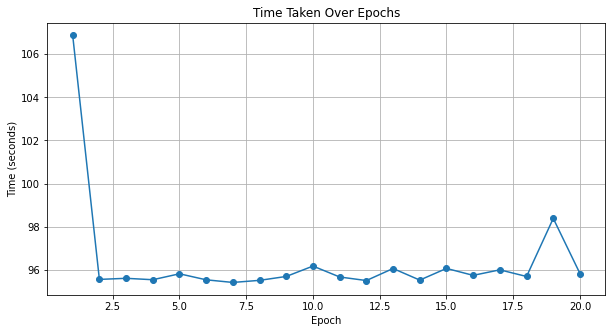

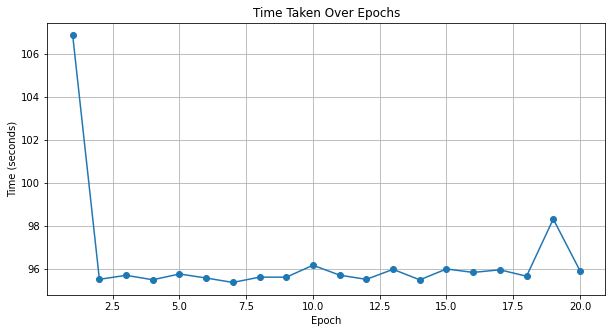

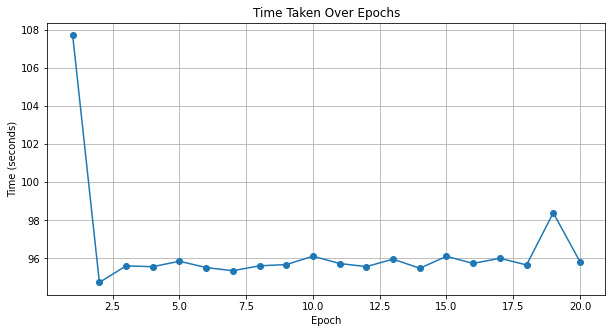

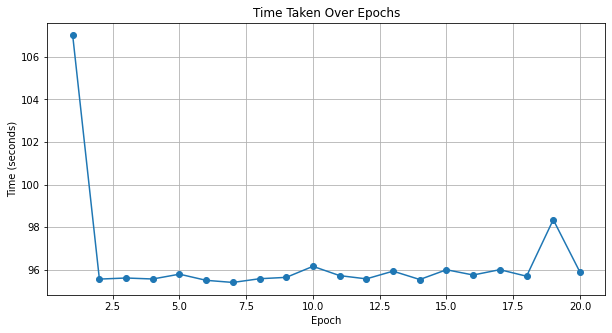

Accuracy: 0.5759
Weighted Average Accuracy: 0.7558
Accuracy: 0.5759
Weighted Average Accuracy: 0.7558
Accuracy: 0.5918
Weighted Average Accuracy: 0.7584
Accuracy: 0.6076
Weighted Average Accuracy: 0.7616


In [7]:
if __name__ == "__main__":
    # Number of processes
    world_size = torch.cuda.device_count()
    print(f'Number of GPUs: {world_size}\n')

    # Start training processes (works for older version)
    # mp.spawn(initialize_and_train, args=(world_size,), nprocs=world_size)

    # Create a list to hold our processes
    processes = []

    # Start a process for each GPU
    for rank in range(world_size):
        """
        Start a separate process for each GPU to initialize and train the model.

        Args:
            rank (int): Rank of the current process in the distributed setup.
            world_size (int): Total number of processes in the distributed setup.
        """
        p = mp.Process(target=initialize_and_train, args=(rank, world_size))
        p.start()
        processes.append(p)


    # Wait for all processes to finish
    for p in processes:
        p.join()